<a href="https://colab.research.google.com/github/Deegayu-Mihiraj/Bank-Marketing-ML-Project/blob/main/ML%20CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

Mount Google Drive and import dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
bankdataset = pd.read_csv('/content/drive/MyDrive/Machine Learning/CW/bank-full.csv', sep=';')

***Data Preprocessing***

In [5]:
# Drop 'duration' column for realistic predictive modeling
bankdataset.drop(columns=['duration'], inplace=True)

In [6]:
bankdataset.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,no


In [7]:
bankdataset.shape

(45211, 16)

In [8]:
bankdataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  campaign   45211 non-null  int64 
 12  pdays      45211 non-null  int64 
 13  previous   45211 non-null  int64 
 14  poutcome   45211 non-null  object
 15  y          45211 non-null  object
dtypes: int64(6), object(10)
memory usage: 5.5+ MB


In [9]:
bankdataset.describe()

,age,balance,day,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,63.000000,871.000000,275.000000


In [10]:
# Check for missing values in the entire dataset
missing_values = bankdataset.isnull().sum()
print(missing_values)

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [11]:
bankdataset.isin(['unknown']).sum()


,0
age,0
job,288
marital,0
education,1857
default,0
balance,0
housing,0
loan,0
contact,13020
day,0


In [12]:
# List of columns where "unknown" should be replaced with the mode
selected_columns = ['job', 'education']

# Replace "unknown" with the mode for the selected columns
for col in selected_columns:
    mode = bankdataset[col].mode()[0]
    bankdataset[col] = bankdataset[col].replace('unknown', mode)


In [29]:
#numeric and categoric columns
integer_columns = bankdataset.select_dtypes(include=['int64'])
string_columns = bankdataset.select_dtypes(include=['object'])

In [15]:
# Remove punctuation
import string

string_columns = bankdataset.select_dtypes(include=['object'])
bankdataset[string_columns.columns] = string_columns.apply(
    lambda col: col.str.replace(f"[{string.punctuation}]", "", regex=True)
)


In [16]:
# Encoding categorical variables
label_encoders = {}
for col in string_columns.columns:
    le = LabelEncoder()
    bankdataset[col] = le.fit_transform(bankdataset[col])
    label_encoders[col] = le

# Encoding target variable 'y'
if 'y' not in label_encoders:  # Check if 'y' is already in label_encoders
    le_y = LabelEncoder()
    bankdataset['y'] = le_y.fit_transform(bankdataset['y'])
    label_encoders['y'] = le_y

print(bankdataset['y'].unique())  # Verify the encoding for the target column

[0 1]


In [17]:
# Scaling numeric features
scaler = StandardScaler()
integer_columns_scaled = scaler.fit_transform(bankdataset[integer_columns.columns])
integer_columns_scaled_df = pd.DataFrame(integer_columns_scaled, columns=integer_columns.columns)

# Combine scaled numeric features with encoded categorical features
bankdataset_preprocessed = pd.concat([integer_columns_scaled_df, bankdataset[string_columns.columns]], axis=1)

In [18]:
# Splitting the dataset into train and test sets
X = bankdataset_preprocessed.drop(columns=['y'])
y = bankdataset_preprocessed['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Train Random Forest Classifier (max_depth to reduce overfitting)
ranfor_model = RandomForestClassifier(random_state=54, max_depth=15)
ranfor_model.fit(X_train, y_train)

# Predictions and Evaluation
y_pred_ranfor = ranfor_model.predict(X_test)
print("Random Forest Classifier Evaluation")
print(classification_report(y_test, y_pred_ranfor))
print("Accuracy:", accuracy_score(y_test, y_pred_ranfor))

Random Forest Classifier Evaluation
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      7952
           1       0.70      0.20      0.31      1091

    accuracy                           0.89      9043
   macro avg       0.80      0.59      0.62      9043
weighted avg       0.88      0.89      0.87      9043

Accuracy: 0.8929558774742895


Feedforward Neural Network

Epoch 1/10
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8852 - loss: 0.3582 - val_accuracy: 0.8815 - val_loss: 0.3310
Epoch 2/10
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8872 - loss: 0.3193 - val_accuracy: 0.8864 - val_loss: 0.3206
Epoch 3/10
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8866 - loss: 0.3186 - val_accuracy: 0.8873 - val_loss: 0.3190
Epoch 4/10
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8901 - loss: 0.3131 - val_accuracy: 0.8870 - val_loss: 0.3159
Epoch 5/10
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8913 - loss: 0.3092 - val_accuracy: 0.8878 - val_loss: 0.3148
Epoch 6/10
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8900 - loss: 0.3125 - val_accuracy: 0.8873 - val_loss: 0.3136
Epoch 7/10
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8894 - loss: 0.3102 - val_accuracy: 0.8884 - val_loss: 0.3138
Epoch 8/10
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8906 - loss: 0.3099 - 

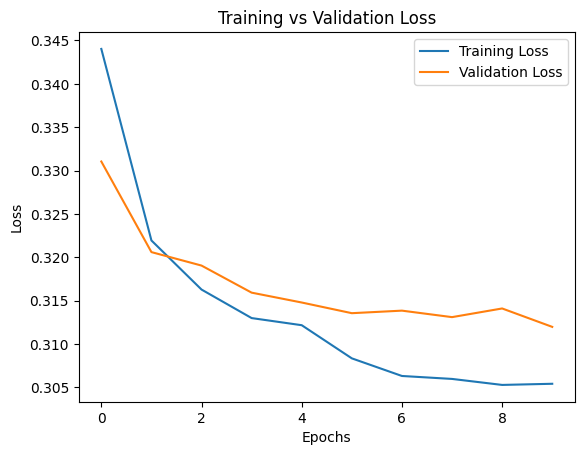

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Neural Network Model
FF_NN_Model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),  # 1 hidden layer
    Dropout(0.3),  # Dropout for regularization
    Dense(64, activation='relu'),  # 2 hidden layer
    Dropout(0.3),  # Dropout for regularization
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the Model
FF_NN_Model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the Model
history = FF_NN_Model.fit(X_train, y_train,epochs=10,batch_size=32, validation_data=(X_test, y_test))

# Evaluate the Model
FF_NN_loss, FF_NN_accuracy = FF_NN_Model.evaluate(X_test, y_test)
print("Neural Network Accuracy on Test Data:", FF_NN_accuracy)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.show()


In [ ]:
# Save the Random Forest Model
joblib.dump(rf_model, 'random_forest_model.pkl')
print("Random Forest model saved as 'random_forest_model.pkl'")

# Save the Neural Network Model
FF_NN_Model.save('neural_network_model.h5')
print("Neural Network model saved as 'neural_network_model.h5'")

# Summary Comparison of Models
print("Summary Comparison:")
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(f"Neural Network Accuracy: {FF_NN_accuracy}")